To resolve the comment: <br/>
Train the autoencoder + classifier for one sensor, then align the latent space of the other to the known latent space, examine the classifier result. (probably with addition/reduced texture classes) <br/>
First case: train BioTac (T4-unspv), then load the model to obtain the "known latent space"

Compared to the joint training, make the following modifications
* load the pretrained model of individual training
* modify training process
* copy the pre-trained classifier right before final testing
* change the recon_loss weight and lr, which may not affect anything

In [1]:
import os,sys
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../new_iteration/")
import pickle
import argparse
from sklearn.metrics import confusion_matrix
from datetime import datetime

from vrae.vrae import VRAEC
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as data2
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from tas_utils_bs import get_trainValLoader, get_testLoader

from torchsummary import summary


In [2]:
# dummy class to replace argparser
class Args:
  kfold = 0
  reduction = 1
  cuda = '0'

args=Args()

In [3]:
print("load {} kfold number, reduce data to {} folds, put to cuda:{}".format(args.kfold, args.reduction, args.cuda))

# Set hyper params
kfold_number = args.kfold
data_reduction_ratio = args.reduction
shuffle = True
num_class = 20
sequence_length_B = 400
sequence_length_I = 75
number_of_features_B = 19
number_of_features_I = 60

hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.001
n_epochs = 200


dropout_rate = 0.2
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
header_B = None
header_I = "CNN"

w_mse = 1 # mse between latent vectors
w_rB = 0.01 # recon for B
w_rI = 0.05 # recon for I
w_cB = 1 # classify for B
w_cI = 1 # classify for I


np.random.seed(1)
torch.manual_seed(1)

load 0 kfold number, reduce data to 1 folds, put to cuda:0


In [4]:
# Load data
data_dir = '../../new_data_folder/'

logDir = 'models_and_stats/'
# pretrained model
model_name_B = "BT19_ae_1_rm_0_wrI_0.01_wC_1_0"
# new model 
model_name_I = "T5-half-spv-I"

if torch.cuda.is_available():
    device = torch.device("cuda:{}".format(args.cuda))
else:
    device = torch.device('cpu')
print("Loading data...")

# manually change the test data
kfold_number = 1
train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=kfold_number, spike_ready=False, batch_size=batch_size, shuffle=shuffle)
test_loader, test_dataset = get_testLoader(data_dir, spike_ready=False, batch_size=batch_size, shuffle=shuffle)


Loading data...


In [5]:
model_B_pretrained = VRAEC(num_class=num_class,
            sequence_length=sequence_length_B,
            number_of_features = number_of_features_B,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_B,
            header=header_B,
            device = device)
model_B_pretrained_dir = logDir+model_name_B+'.pt'
if device  == torch.device('cpu'):
    model_B_pretrained.load_state_dict(torch.load(model_B_pretrained_dir, map_location=torch.device('cpu')))
else:
    model_B_pretrained.load_state_dict(torch.load(model_B_pretrained_dir))
    
model_B_pretrained.to(device)
model_B_pretrained.eval()

print("load model from")
print(model_name_B)

model_I = VRAEC(num_class=num_class,
            sequence_length=sequence_length_I,
            number_of_features = number_of_features_I,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name_I,
            header=header_I,
            device = device)
model_I.to(device)

load model from
BT19_ae_1_rm_0_wrI_0.01_wC_1_0


/home/ruihan/anaconda3/envs/opencv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



VRAE(n_epochs=200,batch_size=32,cuda=False)

In [6]:
criterion = nn.CrossEntropyLoss()
optimI = optim.Adam(model_I.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

In [7]:
# one stage training: with recon_loss and mse_loss
training_start=datetime.now()

# epoch_train_loss_B = []
epoch_train_acc_B = []
# epoch_val_loss_B = []
epoch_val_acc_B = []
# max_val_acc_B = 0

epoch_train_loss_I = []
epoch_train_acc_I = []
epoch_val_loss_I = []
epoch_val_acc_I = []

epoch_val_loss_tot = []
epoch_train_loss_tot = []

max_val_acc_I = 0

for epoch in range(n_epochs):

    # TRAIN
#     model_B.train()
    model_B_pretrained.eval()
    model_I.train()

    correct_B = 0
    train_loss_B = 0
    correct_I = 0
    train_loss_I = 0
    train_loss_tot = 0
    train_num = 0
            
    for i, (XI, XB,  y) in enumerate(train_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        train_num += XI.size(0)
        
        # train model_B
#         optimB.zero_grad()  
        x_decoded_B, latent_B, output = model_B_pretrained(XB)
        
        # construct loss function
#         recon_loss_B = recon_loss_fn(x_decoded_B, XB)
#         cl_loss_B = cl_loss_fn(output, y)
#         loss_B = w_rB*recon_loss_B + w_cB*cl_loss_B
        
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
#         train_loss_B += loss_B.item()
        
        
        # train modelI
        optimI.zero_grad()  
        x_decoded_I, latent_I, output = model_I(XI)
        
        # construct loss function
        recon_loss_I = recon_loss_fn(x_decoded_I, XI)
        cl_loss_I = cl_loss_fn(output, y)
        loss_I = w_rI*recon_loss_I # + w_cI*cl_loss_I

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        train_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        if epoch<20:
            loss = loss_I
        else:
            loss =  loss_I + w_mse*loss_C #+ loss_B
        
#         if epoch < 20:
# #             loss_B.backward()
#             loss_I.backward()
#         else:
#             loss.backward()
        loss.backward()
        
        train_loss_tot += loss.item()
        
#         optimB.step() 
        optimI.step() 
    
    if epoch < 20 or epoch%200 == 0:
        print("last batch training: LI: {:.2f}, LC: {:.2f}, recon_I {:.2f}, cl_I {:.2f}"\
              .format(loss_I, loss_C, recon_loss_I, cl_loss_I))
    
    
    # fill stats
    train_accuracy_B = correct_B / train_num # len(train_loader.dataset)
#     train_loss_B /= train_num #len(train_loader.dataset)
#     epoch_train_loss_B.append(train_loss_B)
    epoch_train_acc_B.append(train_accuracy_B) 
    
    train_accuracy_I = correct_I / train_num # len(train_loader.dataset)
    train_loss_I /= train_num #len(train_loader.dataset)
    epoch_train_loss_I.append(train_loss_I)
    epoch_train_acc_I.append(train_accuracy_I) 
    epoch_train_loss_tot.append(train_loss_tot)
    

    # VALIDATION
    model_B_pretrained.eval()
    model_I.eval()

    correct_B = 0
    val_loss_B = 0
    correct_I = 0
    val_loss_I = 0
    val_loss_tot = 0
    val_num = 0

    for i, (XI, XB,  y) in enumerate(val_loader):
        XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)
        
        if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break

        val_num += XI.size(0)
        
        # eval model_B
        x_decoded_B, latent_B, output = model_B_pretrained(XB)
        # construct loss function
#         recon_loss_B = recon_loss_fn(x_decoded_B, XB)
#         cl_loss_B = cl_loss_fn(output, y)
#         loss_B = w_rB*recon_loss_B + w_cB*cl_loss_B
       
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
#         val_loss_B += loss_B.item()
        
        
        # eval modelI 
        x_decoded_I, latent_I, output = model_I(XI)
        # construct loss function
        recon_loss_I = recon_loss_fn(x_decoded_I, XI)
        cl_loss_I = cl_loss_fn(output, y)
        loss_I = w_rI*recon_loss_I # + w_cI*cl_loss_I

        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        # accumulator
        val_loss_I += loss_I.item()
        
        loss_C = F.mse_loss(latent_B, latent_I)
        loss =  loss_I + w_mse*loss_C # + loss_B
        val_loss_tot += loss.item()

    # fill stats
    val_accuracy_B = correct_B / val_num # len(train_loader.dataset)
#     val_loss_B /= val_num #len(train_loader.dataset)
#     epoch_val_loss_B.append(val_loss_B)
    epoch_val_acc_B.append(val_accuracy_B) 
    
    val_accuracy_I = correct_I / val_num # len(train_loader.dataset)
    val_loss_I /= val_num #len(train_loader.dataset)
    epoch_val_loss_I.append(val_loss_I)
    epoch_val_acc_I.append(val_accuracy_I) 
    epoch_val_loss_tot.append(val_loss_tot)
    
    if epoch < 20 or epoch%200 == 0:
#         print("train_num {}, val_num {}".format(train_num, val_num))
        print("Epoch {}: Loss: lc {:.3f},  train_I {:.3f}, val_I {:.3f}, \n\t Acc: train_B {:.3f}, val_B {:.3f}, train_I {:.3f}, val_I {:.3f}"\
              .format(epoch, loss_C, train_loss_I, val_loss_I, train_accuracy_B, val_accuracy_B, train_accuracy_I, val_accuracy_I))
        print("-"*20)

    # choose model
    # TODO: not save at the same time, may have bad common representation
#     if max_val_acc_B <= val_accuracy_B:
#         model_dir = logDir + model_name_B + '.pt'
#         print("Saving model at {} epoch to {}".format(epoch, model_dir))
#         max_val_acc_B = val_accuracy_B
#         torch.save(model_B.state_dict(), model_dir)

    if max_val_acc_I <= val_accuracy_I:
        model_dir = logDir + model_name_I + '.pt'
        print("Saving model at {} epoch to {}".format(epoch, model_dir))
        max_val_acc_I = val_accuracy_I
        torch.save(model_I.state_dict(), model_dir)
    

training_end =  datetime.now()
training_time = training_end -training_start 
print("RAE training takes time {}".format(training_time)) 

last batch training: LI: 11.40, LC: 7.51, recon_I 227.91, cl_I 3.27
Epoch 0: Loss: lc 7.465,  train_I 0.359, val_I 0.344, 
	 Acc: train_B 0.991, val_B 1.000, train_I 0.050, val_I 0.052
--------------------
Saving model at 0 epoch to models_and_stats/T5-half-spv-I.pt
last batch training: LI: 12.07, LC: 13.67, recon_I 241.30, cl_I 3.53
Epoch 1: Loss: lc 13.823,  train_I 0.355, val_I 0.345, 
	 Acc: train_B 0.990, val_B 1.000, train_I 0.052, val_I 0.052
--------------------
Saving model at 1 epoch to models_and_stats/T5-half-spv-I.pt
last batch training: LI: 9.74, LC: 16.16, recon_I 194.74, cl_I 4.26
Epoch 2: Loss: lc 16.762,  train_I 0.346, val_I 0.341, 
	 Acc: train_B 0.990, val_B 1.000, train_I 0.052, val_I 0.042
--------------------
last batch training: LI: 11.00, LC: 16.66, recon_I 220.06, cl_I 3.77
Epoch 3: Loss: lc 17.447,  train_I 0.346, val_I 0.341, 
	 Acc: train_B 0.990, val_B 1.000, train_I 0.040, val_I 0.052
--------------------
Saving model at 3 epoch to models_and_stats/T5-ha

In [8]:
model_B_pretrained.is_fitted = True
model_I.is_fitted = True

model_B_pretrained.eval()
model_I.eval()

VRAE(n_epochs=200,batch_size=32,cuda=False)

In [9]:
# copy the classifier from B to I to examine the classification result
classifier_keys = ['classifier.0.weight', 'classifier.0.bias']
classifier_dict_B = {k: v for k, v in model_B_pretrained.state_dict().items() if k in classifier_keys}
classifier_dict_I = {k: v for k, v in model_I.state_dict().items() if k in classifier_keys}
ae_dict_B = {k: v for k, v in model_B_pretrained.state_dict().items() if k not in classifier_keys}
ae_dict_I = {k: v for k, v in model_I.state_dict().items() if k not in classifier_keys}

newI_dict = model_I.state_dict()
newI_dict.update(ae_dict_I)
# overwrite classifer for new models
newI_dict.update(classifier_dict_B)
# load the new state_dict
model_I.load_state_dict(newI_dict)
model_I.to(device)
model_I.eval()
print(model_I)

VRAE(n_epochs=200,batch_size=32,cuda=False)


In [10]:
# TEST
correct_B = 0
correct_I = 0
test_num = 0

for i, (XI, XB,  y) in enumerate(test_loader):
    XI, XB, y = XI.to(device), XB.to(device), y.long().to(device)

    if XI.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break

    test_num += XI.size(0)

    # test model_B
    x_decoded_B, latent_B, output = model_B_pretrained(XB)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_B += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

    
    # test modelI 
    x_decoded_I, latent_I, output = model_I(XI)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct_I += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

test_acc_B = correct_B/test_num
test_acc_I = correct_I/test_num
print('Test accuracy for {} fold {} samples: B {}, I {}'.format(str(kfold_number),test_num, test_acc_B, test_acc_I))

Test accuracy for 1 fold 192 samples: B 0.9635416666666666, I 0.9166666666666666


In [11]:
# save stats
# results_dict = {"epoch_train_loss_B": epoch_train_loss_B,
#                 "epoch_train_loss_I": epoch_train_loss_I,
#                 "epoch_val_loss_B": epoch_val_loss_B,
#                 "epoch_val_loss_I": epoch_val_loss_I,
#                 "epoch_train_acc_B": epoch_train_acc_B,
#                 "epoch_train_acc_I": epoch_train_acc_I,
#                 "epoch_val_acc_B": epoch_val_acc_B,
#                 "epoch_val_acc_I": epoch_val_acc_I,
#                 "test_acc": [test_acc_B, test_acc_I]}

# since we examine the classifier at the last step, the train acc and val acc do not matter
results_dict = {"epoch_train_loss_I": epoch_train_loss_I,
                "epoch_val_loss_I": epoch_val_loss_I,
                "epoch_train_loss_tot": epoch_train_loss_tot,
                "epoch_val_loss_tot": epoch_val_loss_tot,
#                 "epoch_train_acc_B": epoch_train_acc_B,
#                 "epoch_train_acc_I": epoch_train_acc_I,
#                 "epoch_val_acc_B": epoch_val_acc_B,
#                 "epoch_val_acc_I": epoch_val_acc_I,
                "test_acc": [test_acc_B, test_acc_I]}
dict_name = "T5_BT19Icub_joint_ae_wrB_{}_wcB_{}_wrI_{}_wcI_{}_wC_{}_{}_trainI.pkl".format(w_rB, w_cB, w_rI, w_cI, w_mse, str(kfold_number))
pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
print("dump results dict to {}".format(dict_name))


dump results dict to T5_BT19Icub_joint_ae_wrB_0.01_wcB_1_wrI_0.05_wcI_1_wC_1_1.pkl


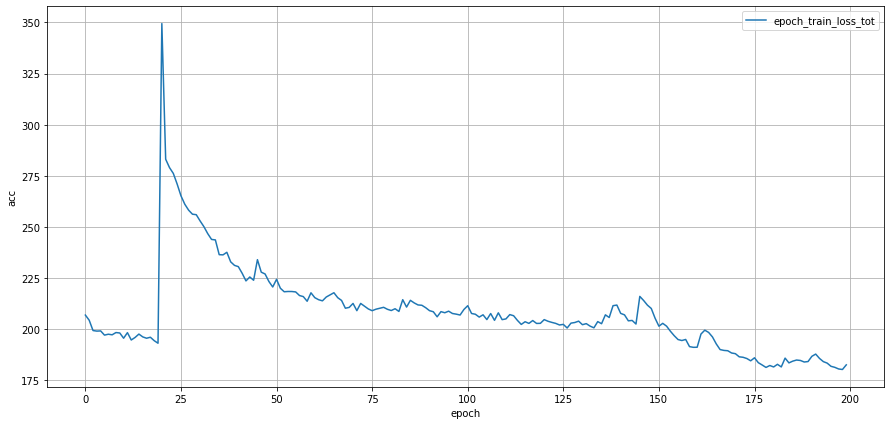

In [12]:
# plot loss
assert n_epochs == len(epoch_train_loss_tot), "different epoch length {} {}".format(n_epochs, len(epoch_train_loss_tot))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_loss_tot, label="epoch_train_loss_tot")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name_I + "_train_loss_tot.png"
plt.savefig(figname)
plt.show()
